In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

base_path = "/content/drive/MyDrive/ds_tanisha_das"
os.makedirs(f"{base_path}/csv_files", exist_ok=True)
os.makedirs(f"{base_path}/outputs", exist_ok=True)

In [7]:
import pandas as pd

# Paths
trader_path = f"{base_path}/csv_files/trader_data.csv"
sentiment_path = f"{base_path}/csv_files/sentiment_data.csv"

# Load data
traders = pd.read_csv(trader_path)
sentiment = pd.read_csv(sentiment_path)

# Quick preview
print(traders.head())
print(sentiment.head())


                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9894   

   Size Tokens  Size USD Side     Timestamp IST  Start Position Direction  \
0       986.87   7872.16  BUY  02-12-2024 22:50        0.000000       Buy   
1        16.00    127.68  BUY  02-12-2024 22:50      986.524596       Buy   
2       144.09   1150.63  BUY  02-12-2024 22:50     1002.518996       Buy   
3       142.98   1142.04  BUY  02-12-2024 22:50     1146.558564       Buy   
4         8.73     69.75  BUY  02-12-2024 22:50     1289.488521       Buy   

   Closed PnL                                   Transaction Hash     Order ID  \
0         0.0  0xec0945

In [9]:
# Clean trader column names
traders.columns = traders.columns.str.lower().str.replace(" ", "_")

# Check cleaned column names
print(traders.columns)

Index(['account', 'coin', 'execution_price', 'size_tokens', 'size_usd', 'side',
       'timestamp_ist', 'start_position', 'direction', 'closed_pnl',
       'transaction_hash', 'order_id', 'crossed', 'fee', 'trade_id',
       'timestamp'],
      dtype='object')


In [10]:
# Convert IST timestamp to datetime format
traders['timestamp_ist'] = pd.to_datetime(traders['timestamp_ist'], format="%d-%m-%Y %H:%M")
traders['date'] = traders['timestamp_ist'].dt.date

In [11]:
# Rename for consistency
sentiment.columns = sentiment.columns.str.lower()
sentiment.rename(columns={"classification": "sentiment"}, inplace=True)

# Convert to datetime
sentiment['date'] = pd.to_datetime(sentiment['date']).dt.date

In [14]:
# Merge on common date
merged = pd.merge(traders, sentiment[['date', 'sentiment']], on='date', how='inner')

# Preview
print(merged[['account', 'execution_price', 'size_tokens', 'closed_pnl', 'sentiment']].head())

                                      account  execution_price  size_tokens  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9769       986.87   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9800        16.00   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9855       144.09   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9874       142.98   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9894         8.73   

   closed_pnl      sentiment  
0         0.0  Extreme Greed  
1         0.0  Extreme Greed  
2         0.0  Extreme Greed  
3         0.0  Extreme Greed  
4         0.0  Extreme Greed  


In [16]:
#calculating roi for efficiency
# Avoid division by zero errors
merged['roi'] = merged.apply(
    lambda row: row['closed_pnl'] / (row['execution_price'] * row['size_tokens'])
    if row['execution_price'] * row['size_tokens'] != 0 else 0, axis=1
)

# Preview
print(merged[['account', 'execution_price', 'size_tokens', 'closed_pnl', 'roi', 'sentiment']].head())

                                      account  execution_price  size_tokens  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9769       986.87   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9800        16.00   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9855       144.09   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9874       142.98   
4  0xae5eacaf9c6b9111fd53034a602c192a04e082ed           7.9894         8.73   

   closed_pnl  roi      sentiment  
0         0.0  0.0  Extreme Greed  
1         0.0  0.0  Extreme Greed  
2         0.0  0.0  Extreme Greed  
3         0.0  0.0  Extreme Greed  
4         0.0  0.0  Extreme Greed  


In [17]:
merged.to_csv(f"{base_path}/csv_files/merged_data.csv", index=False)

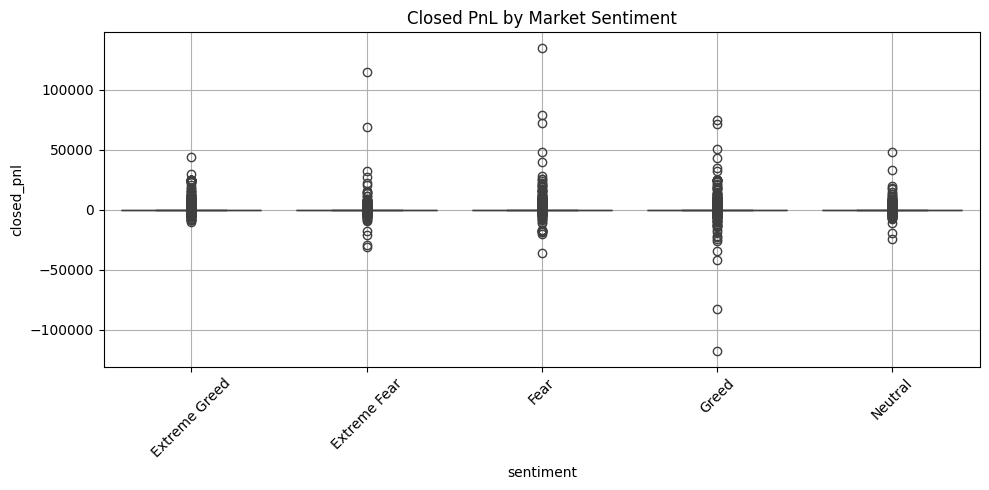

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
sns.boxplot(x='sentiment', y='closed_pnl', data=merged)
plt.title('Closed PnL by Market Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{base_path}/outputs/pnl_sentiment.png")
plt.show()

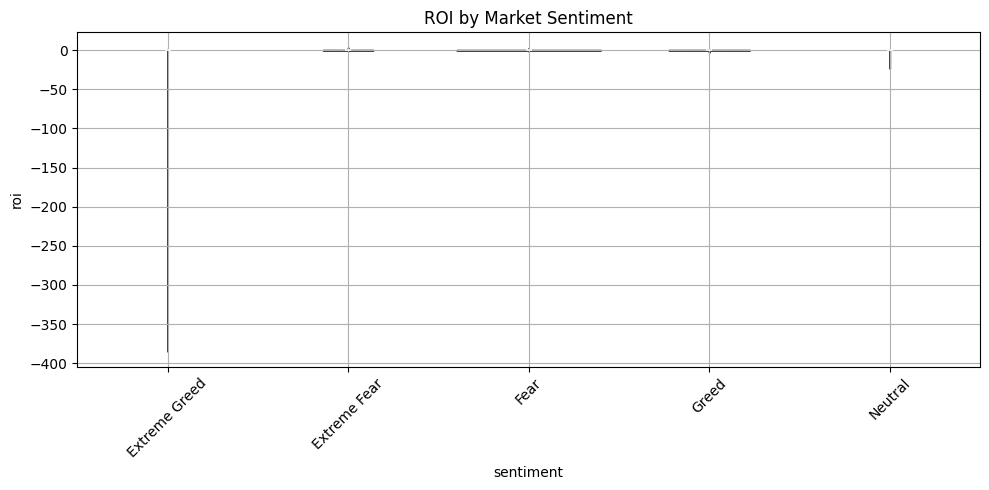

In [19]:
plt.figure(figsize=(10,5))
sns.violinplot(x='sentiment', y='roi', data=merged)
plt.title('ROI by Market Sentiment')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"{base_path}/outputs/roi_sentiment.png")
plt.show()

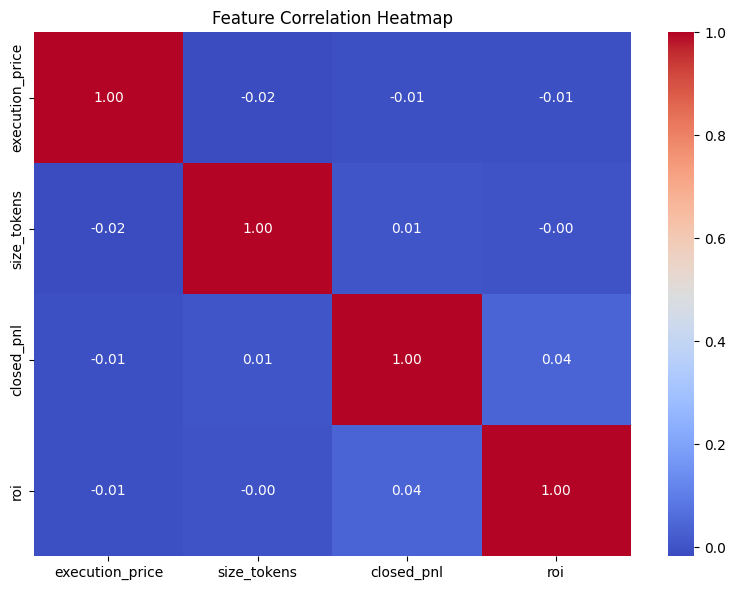

In [20]:
plt.figure(figsize=(8,6))
corr = merged[['execution_price', 'size_tokens', 'closed_pnl', 'roi']].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig(f"{base_path}/outputs/correlation.png")
plt.show()

In [21]:
# Group by trader account and sentiment
grouped = merged.groupby(['account', 'sentiment']).agg({
    'roi': 'mean',
    'closed_pnl': 'sum',
    'size_tokens': 'sum'
}).reset_index()

# Rename for clarity
grouped.rename(columns={
    'roi': 'avg_roi',
    'closed_pnl': 'total_pnl',
    'size_tokens': 'total_volume'
}, inplace=True)

# Preview
print(grouped.head())

                                      account      sentiment   avg_roi  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012   Extreme Fear  0.052553   
1  0x083384f897ee0f19899168e3b1bec365f52a9012  Extreme Greed -0.001763   
2  0x083384f897ee0f19899168e3b1bec365f52a9012           Fear  0.053921   
3  0x083384f897ee0f19899168e3b1bec365f52a9012          Greed  0.030677   
4  0x083384f897ee0f19899168e3b1bec365f52a9012        Neutral  0.017256   

      total_pnl  total_volume  
0  1.247692e+05      659.3362  
1 -4.028234e+04    20430.8800  
2  1.113374e+06    20365.3212  
3  2.767193e+05    16599.8000  
4  1.256501e+05     3671.0498  


In [22]:
top_fear = grouped[grouped['sentiment'].str.lower().str.contains("fear")].sort_values(
    by='avg_roi', ascending=False
).head(10)

print("🔹 Top 10 Traders During Fear Sentiment:")
print(top_fear[['account', 'avg_roi', 'total_pnl', 'total_volume']])

🔹 Top 10 Traders During Fear Sentiment:
                                        account   avg_roi     total_pnl  \
82   0x72c6a4624e1dffa724e6d00d64ceae698af892a0  0.194775  1.445143e+05   
42   0x420ab45e0bd8863569a5efbb9c05d91f40624641  0.182760  9.964828e+04   
95   0x8170715b3b381dffb7062c0298972d4727a0a63b  0.119488  1.271349e+04   
97   0x8170715b3b381dffb7062c0298972d4727a0a63b  0.094463  1.512927e+05   
80   0x72c6a4624e1dffa724e6d00d64ceae698af892a0  0.094153  1.989006e+05   
148  0xbd5fead7180a9c139fa51a103cb6a2ce86ddb5c3  0.082437  2.367977e+05   
2    0x083384f897ee0f19899168e3b1bec365f52a9012  0.053921  1.113374e+06   
85   0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4  0.053027  2.567284e+04   
0    0x083384f897ee0f19899168e3b1bec365f52a9012  0.052553  1.247692e+05   
20   0x2c229d22b100a7beb69122eed721cee9b24011dd  0.050141  1.141525e+04   

     total_volume  
82   1.384615e+06  
42   3.648636e+04  
95   1.560876e+05  
97   2.755628e+06  
80   4.450620e+05  
148  1.971830e

In [23]:
top_greed = grouped[grouped['sentiment'].str.lower().str.contains("greed")].sort_values(
    by='avg_roi', ascending=False
).head(10)

print("🔹 Top 10 Traders During Greed Sentiment:")
print(top_greed[['account', 'avg_roi', 'total_pnl', 'total_volume']])

🔹 Top 10 Traders During Greed Sentiment:
                                        account   avg_roi     total_pnl  \
46   0x430f09841d65beb3f27765503d0f850b8bce7713  0.999997  1.242849e+05   
71   0x6d6a4b953f202f8df5bed40692e7fd865318264a  0.673870  7.319208e+04   
123  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  0.392115  4.416981e+04   
73   0x6d6a4b953f202f8df5bed40692e7fd865318264a  0.337769  3.020340e+04   
121  0xa520ded057a32086c40e7dd6ed4eb8efb82c00e0  0.309269  4.641127e+04   
135  0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23  0.304508  1.105305e+06   
11   0x271b280974205ca63b716753467d5a371de622ab  0.201586  1.793160e+03   
48   0x430f09841d65beb3f27765503d0f850b8bce7713  0.180604  2.276805e+05   
144  0xbaaaf6571ab7d571043ff1e313a9609a10637864  0.093251  4.672458e+00   
128  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  0.080754  3.816835e+04   

     total_volume  
46   3.887328e+04  
71   4.673550e+03  
123  3.272453e+05  
73   4.832174e+04  
121  2.072015e+05  
135  1.156440